# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import os
import math

import ta

# using the style for the plot
plt.style.use('classic')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

# %config inlinebackend.figure_format = 'svg'

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import sys

sys.path.insert(0, 'D:/Intraday_trading')

In [5]:
from src.support import *

# Data

In [6]:
%%time

interval_data = pd.read_pickle('D:/Intraday_trading/Training/Data/XAUUSD_M1.pkl')

interval_data = interval_data.set_index('DATE_TIME')
interval_data.index = pd.to_datetime(interval_data.index)

interval_data['DATE'] = pd.to_datetime(interval_data['DATE'])
interval_data['OPEN'] = interval_data['OPEN']
interval_data['HIGH'] = interval_data['HIGH']
interval_data['LOW'] = interval_data['LOW']
interval_data['CLOSE'] = interval_data['CLOSE']


CPU times: total: 125 ms
Wall time: 229 ms


In [7]:
interval_data.shape

(1560355, 8)

In [8]:
list_of_dates = sorted(set(interval_data.index.date))

In [9]:
len(list_of_dates)

1370

# Daily trading volatility

Measure by sum square of minutes returns in a day. ADJUSTED by the number of time they revert.

In [28]:
df_1_min = prepare_df(interval_data,
                      timeframe = '1min')


In [29]:


df_1_min = df_1_min.dropna()
df_1_min = df_1_min[df_1_min.index >= datetime.strptime(str(df_1_min.index[0] + timedelta(days = 1))[:10], '%Y-%m-%d')
]


df_1_day = prepare_df(interval_data,
                      timeframe = '1D')

df_1_day['ROLLING_VOLATILITY(t)'] = df_1_day['Ret(t)'].rolling(window = 5).std()

In [12]:
from arch import arch_model

res_model = arch_model(df_1_day['Ret(t)'].copy().dropna(),
                       p = 1,
                       q = 1,
                       mean = 'Zero',
                       vol = 'GARCH',
                       dist = 'ged')

GARCH = res_model.fit(update_freq = 0,
                      disp = 'off')

In [13]:
GARCH_vol = GARCH.conditional_volatility

In [14]:
list_of_dates = sorted(set(df_1_min.index.date))

# list_of_dates

In [15]:
norm_arr = []
ad_arr = []
trade_range_arr = []
num_revert_arr = []
std_arr = []
epsilon = 1e-3

for idd, date in enumerate(list_of_dates):
    test = df_1_min.loc[df_1_min.index.date == list_of_dates[idd]]

    sum_square_ret = np.sum(test['Ret(t)']**2)
    std_ret = test['Ret(t)'].std()

    max_range = np.absolute(test['HIGH'].max() - test['LOW'].min())

    order = 60

    local_max_indices = argrelmax(data = test.iloc[order: -order, :]['HIGH'].values, axis = 0, order = order)[0]
    local_min_indices = argrelmin(data = test.iloc[order: -order, :]['LOW'].values, axis = 0, order = order)[0]

    num_revert = len(local_max_indices) + len(local_min_indices)


    trade_range_arr.append(max_range)
    num_revert_arr.append(num_revert)
    std_arr.append(std_ret*np.sqrt(250))
    norm_arr.append(np.sqrt(sum_square_ret))
    ad_arr.append(np.sqrt(sum_square_ret*num_revert/max_range))




In [16]:
len(list_of_dates), len(norm_arr), len(ad_arr), len(df_1_day['ROLLING_VOLATILITY(t)'])

(1369, 1369, 1369, 1370)

In [17]:
daily_volatility = pd.DataFrame(index = list_of_dates)
daily_volatility['SUM_SQUARE_VOL'] = norm_arr
daily_volatility['STD_VOL'] = std_arr
daily_volatility['ADJ_SUM_SQUARE_VOL'] = ad_arr
daily_volatility['TRADING_RANGE'] = trade_range_arr
daily_volatility['NUM_REVERT'] = num_revert_arr

In [18]:
daily_volatility = pd.merge(daily_volatility, df_1_day['ROLLING_VOLATILITY(t)'], how = 'left', left_index = True, right_index = True)
daily_volatility = pd.merge(daily_volatility, GARCH_vol, how = 'left', left_index = True, right_index = True)

In [19]:
daily_volatility['FLAG_INCREASE_RISK'] = np.where(daily_volatility['SUM_SQUARE_VOL'] < daily_volatility['ADJ_SUM_SQUARE_VOL'], 1, 0)

In [20]:
daily_volatility['FLAG_INCREASE_RISK'].sum(), len(daily_volatility)

(194, 1369)

In [21]:
daily_volatility.columns = ['SUM_SQUARE_VOL', 'STD_VOL', 'ADJ_SUM_SQUARE_VOL', 'TRADING_RANGE', 'NUM_REVERT','ROLLING_DAILY_VOLATILITY', 'GARCH_DAILY_VOL', 'FLAG_INCREASE_RISK']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4960\1118584588.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


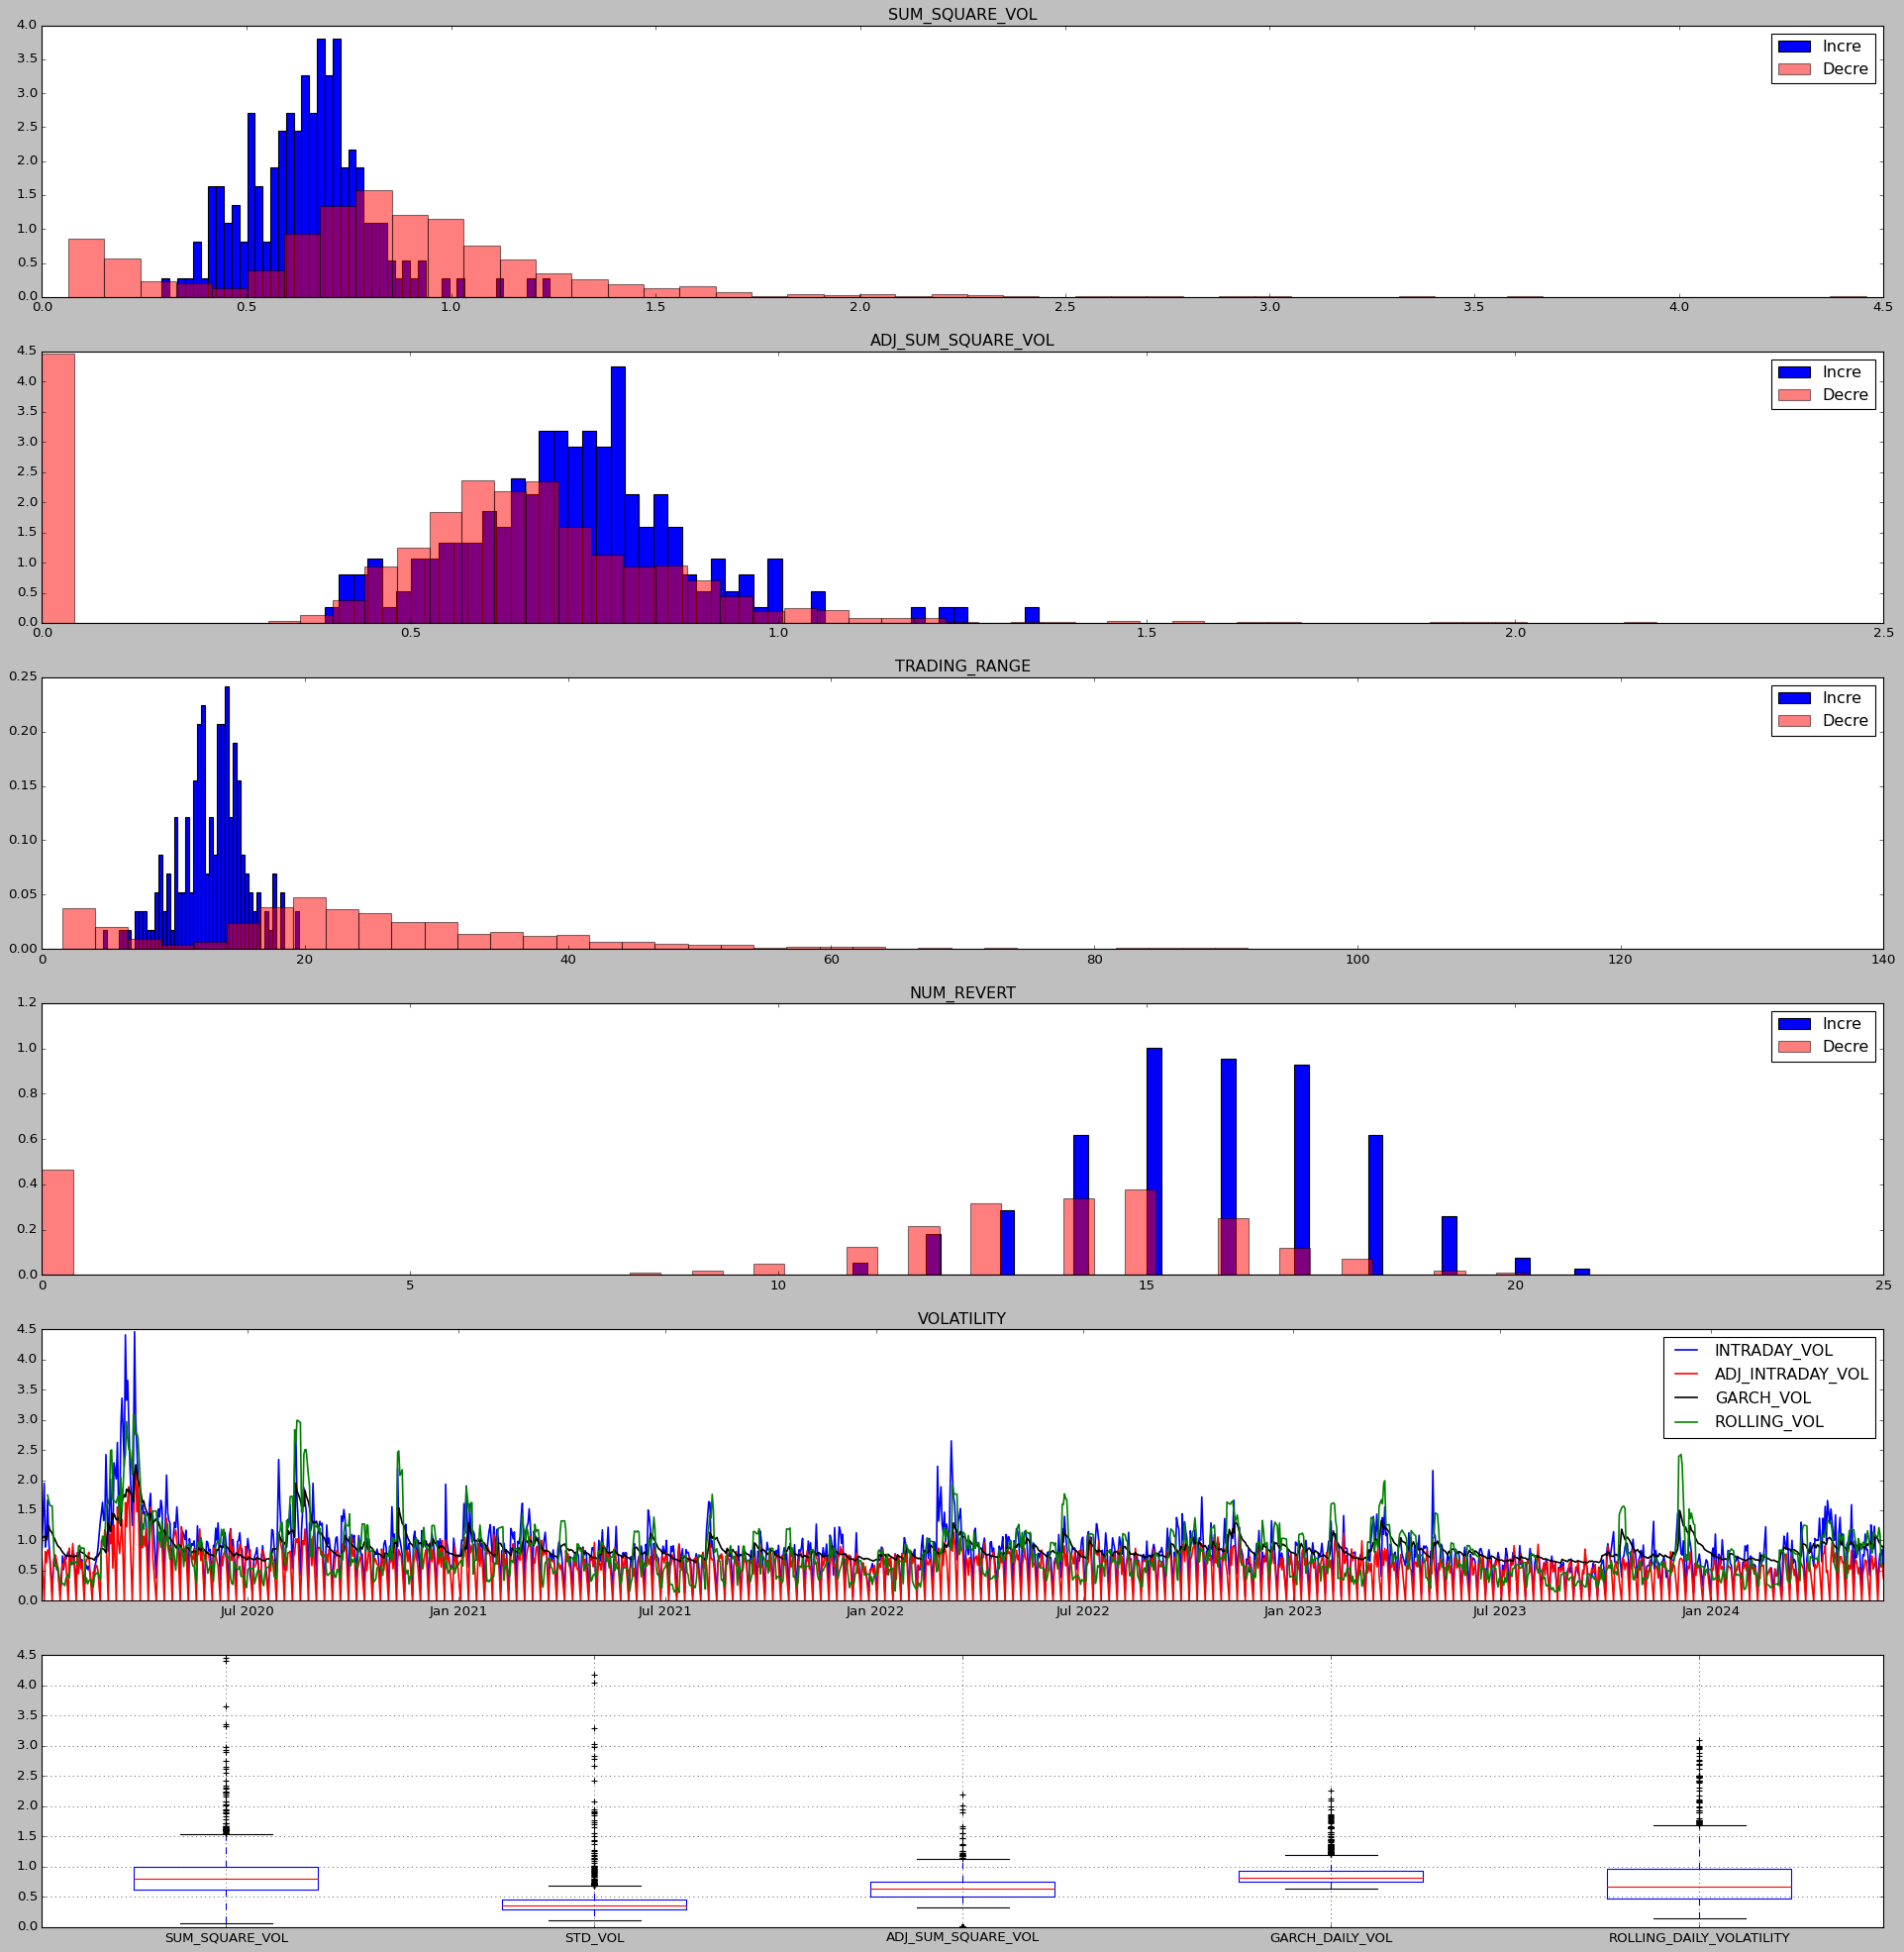

In [22]:
fig, ax = plt.subplots(nrows = 6,
                       ncols = 1,
                       figsize = (30, 30))

ax[0].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 1, 'SUM_SQUARE_VOL'], bins = 50, alpha = 1, color = 'blue', label = 'Incre', density = True)
ax[0].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 0, 'SUM_SQUARE_VOL'], bins = 50, alpha = 0.5, color = 'red', label = 'Decre', density = True)
ax[0].set_title('SUM_SQUARE_VOL')
ax[0].legend()

ax[1].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 1, 'ADJ_SUM_SQUARE_VOL'], bins = 50, alpha = 1, color = 'blue', label = 'Incre', density = True)
ax[1].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 0, 'ADJ_SUM_SQUARE_VOL'], bins = 50, alpha = 0.5, color = 'red', label = 'Decre', density = True)
ax[1].set_title('ADJ_SUM_SQUARE_VOL')
ax[1].legend()

ax[2].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 1, 'TRADING_RANGE'], bins = 50, alpha = 1, color = 'blue', label = 'Incre', density = True)
ax[2].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 0, 'TRADING_RANGE'], bins = 50, alpha = 0.5, color = 'red', label = 'Decre', density = True)
ax[2].set_title('TRADING_RANGE')
ax[2].legend()

ax[3].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 1, 'NUM_REVERT'], bins = 50, alpha = 1, color = 'blue', label = 'Incre', density = True)
ax[3].hist(daily_volatility.loc[daily_volatility['FLAG_INCREASE_RISK'] == 0, 'NUM_REVERT'], bins = 50, alpha = 0.5, color = 'red', label = 'Decre', density = True)
ax[3].set_title('NUM_REVERT')
ax[3].legend()

ax[4].plot(daily_volatility['SUM_SQUARE_VOL'], color = 'blue', label = 'INTRADAY_VOL', linewidth = 1.5)
# ax[4].plot(daily_volatility['STD_VOL'], color = 'orange', label = 'STD_VOL', linewidth = 1.5)
ax[4].plot(daily_volatility['ADJ_SUM_SQUARE_VOL'], color = 'red', label = 'ADJ_INTRADAY_VOL', linewidth = 1.5)
ax[4].plot(daily_volatility['GARCH_DAILY_VOL'], color = 'black', label = 'GARCH_VOL', linewidth = 1.5)
ax[4].plot(daily_volatility['ROLLING_DAILY_VOLATILITY'], color = 'green', label = 'ROLLING_VOL', linewidth = 1.5)
ax[4].set_title('VOLATILITY')
ax[4].legend()

daily_volatility[['SUM_SQUARE_VOL', 'STD_VOL', 'ADJ_SUM_SQUARE_VOL', 'GARCH_DAILY_VOL', 'ROLLING_DAILY_VOLATILITY']].boxplot(ax = ax[5])

fig.show()

# Modeling

In [31]:
df_1_day['CURR_DATE'] = df_1_day.index
df_1_day['PREVIOUS_DATE'] = df_1_day['CURR_DATE'].shift(1)


df_1_day = pd.merge(df_1_day, 
                    daily_volatility[['SUM_SQUARE_VOL', 
                                     'TRADING_RANGE', 
                                     'NUM_REVERT']], 
                    how = 'left', 
                    left_index = True, 
                    right_index = True)



In [34]:
df_1_day['ADJ_SUM_SQUARE_VOL'] = df_1_day['SUM_SQUARE_VOL']*10*df_1_day['NUM_REVERT']/df_1_day['TRADING_RANGE']

In [40]:
df_1_day['ADJ_SUM_SQUARE_VOL(T+1)'] = df_1_day['ADJ_SUM_SQUARE_VOL'].shift(-1)

In [41]:
display(df_1_min.head()), display(df_1_day.head())


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICK_VOL,SPREAD,AVG_PRICE,FLAG_INCREASE_CANDLE,BODY,UPPER_SHADOW,LOWER_SHADOW,FLAG_LONG_UPPER_SHADOW,FLAG_LONG_LOWER_SHADOW,FLAG_HIGHER_HIGH(20),FLAG_HIGHER_LOW(20),AVG_VOL(50),FLAG_OVER_AVG_VOL(50),AVG_VOL(200),FLAG_OVER_AVG_VOL(200),FLAG_UPTREND_VOL(20),RSI,FLAG_UNDER_30_RSI,FLAG_OVER_70_RSI,FLAG_UPTREND_RSI(20),EMA(50),POSITION_EMA(50),EMA(200),POSITION_EMA(200),Ret(t)
DATE_TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03 00:00:00,2020-01-03,00:00:00,1528.725,1529.168,1528.725,1529.137,42,260,1528.93875,1,0.412,0.031,0.000,0,0,1,1,20.72,1,27.500,1,1,78.123439,0,1,1,1528.340626,5,1527.935962,5,0.025773
2020-01-03 00:01:00,2020-01-03,00:01:00,1529.135,1529.336,1529.107,1529.234,32,260,1529.20300,1,0.099,0.102,0.028,1,0,1,1,20.92,1,27.470,1,1,79.555000,0,1,1,1528.375660,5,1527.948877,5,0.006343
2020-01-03 00:02:00,2020-01-03,00:02:00,1529.193,1529.234,1529.102,1529.115,33,260,1529.16100,0,0.078,0.041,0.013,0,0,1,1,21.06,1,27.500,1,1,73.224375,0,1,1,1528.404654,5,1527.960481,5,-0.007782
2020-01-03 00:03:00,2020-01-03,00:03:00,1529.158,1529.180,1529.095,1529.095,28,260,1529.13200,0,0.063,0.022,0.000,0,0,1,1,21.14,1,27.480,1,1,72.184714,0,1,1,1528.431726,5,1527.971769,5,-0.001308
2020-01-03 00:04:00,2020-01-03,00:04:00,1529.093,1529.216,1529.093,1529.187,27,260,1529.14725,1,0.094,0.029,0.000,0,0,1,1,21.32,1,27.435,0,1,74.012571,0,1,1,1528.461345,5,1527.983861,5,0.006017


,OPEN,HIGH,LOW,CLOSE,TICK_VOL,AVG_PRICE,FLAG_INCREASE_CANDLE,BODY,UPPER_SHADOW,LOWER_SHADOW,FLAG_LONG_UPPER_SHADOW,FLAG_LONG_LOWER_SHADOW,FLAG_HIGHER_HIGH(20),FLAG_HIGHER_LOW(20),AVG_VOL(50),FLAG_OVER_AVG_VOL(50),AVG_VOL(200),FLAG_OVER_AVG_VOL(200),FLAG_UPTREND_VOL(20),RSI,FLAG_UNDER_30_RSI,FLAG_OVER_70_RSI,FLAG_UPTREND_RSI(20),EMA(50),POSITION_EMA(50),EMA(200),POSITION_EMA(200),Ret(t),ROLLING_VOLATILITY(t),CURR_DATE,PREVIOUS_DATE,SUM_SQUARE_VOL,TRADING_RANGE,NUM_REVERT,ADJ_SUM_SQUARE_VOL,ADJ_SUM_SQUARE_VOL(T+1)
DATE_TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1518.464,1531.275,1517.172,1528.743,49227,1523.91350,1,10.279,2.532,1.292,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,NaN,NaN,2020-01-02,NaT,NaN,NaN,NaN,NaN,5.621705
2020-01-03,1528.725,1553.419,1528.725,1551.883,66506,1540.68800,1,23.158,1.536,0.000,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.513662,NaN,2020-01-03,2020-01-02,0.867640,24.694,16.0,5.621705,0.000000
2020-01-05,1577.360,1582.102,1566.855,1569.216,5727,1573.88325,0,8.144,4.742,2.361,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.116901,NaN,2020-01-05,2020-01-03,1.947632,15.247,0.0,0.000000,7.445560
2020-01-06,1569.151,1579.966,1560.818,1563.706,71962,1568.41025,0,5.445,10.815,2.888,1,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,-0.351131,NaN,2020-01-06,2020-01-05,0.891047,19.148,16.0,7.445560,3.599231
2020-01-07,1563.723,1598.344,1555.277,1595.013,74597,1578.08925,1,31.290,3.331,8.446,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,2.002103,NaN,2020-01-07,2020-01-06,1.107200,43.067,14.0,3.599231,4.241599


(None, None)

In [44]:
df_1_min.shape, df_1_min.dropna().shape

((1559037, 31), (1559037, 31))

In [45]:
df_1_day.shape, df_1_day.dropna().shape

((1370, 36), (1170, 36))

In [36]:
df = pd.merge(df_1_day, df_1_min, how = 'left', left_on = 'PREVIOUS_DATE', right_on = 'DATE', suffixes = ('_day', '_1min'))
df.index = df['CURR_DATE']

In [37]:
df.head()

,OPEN_day,HIGH_day,LOW_day,CLOSE_day,TICK_VOL_day,AVG_PRICE_day,FLAG_INCREASE_CANDLE_day,BODY_day,UPPER_SHADOW_day,LOWER_SHADOW_day,FLAG_LONG_UPPER_SHADOW_day,FLAG_LONG_LOWER_SHADOW_day,FLAG_HIGHER_HIGH(20)_day,FLAG_HIGHER_LOW(20)_day,AVG_VOL(50)_day,FLAG_OVER_AVG_VOL(50)_day,AVG_VOL(200)_day,FLAG_OVER_AVG_VOL(200)_day,FLAG_UPTREND_VOL(20)_day,RSI_day,FLAG_UNDER_30_RSI_day,FLAG_OVER_70_RSI_day,FLAG_UPTREND_RSI(20)_day,EMA(50)_day,POSITION_EMA(50)_day,EMA(200)_day,POSITION_EMA(200)_day,Ret(t)_day,ROLLING_VOLATILITY(t),CURR_DATE,PREVIOUS_DATE,SUM_SQUARE_VOL,TRADING_RANGE,NUM_REVERT,ADJ_SUM_SQUARE_VOL,DATE,TIME,OPEN_1min,HIGH_1min,LOW_1min,CLOSE_1min,TICK_VOL_1min,SPREAD,AVG_PRICE_1min,FLAG_INCREASE_CANDLE_1min,BODY_1min,UPPER_SHADOW_1min,LOWER_SHADOW_1min,FLAG_LONG_UPPER_SHADOW_1min,FLAG_LONG_LOWER_SHADOW_1min,FLAG_HIGHER_HIGH(20)_1min,FLAG_HIGHER_LOW(20)_1min,AVG_VOL(50)_1min,FLAG_OVER_AVG_VOL(50)_1min,AVG_VOL(200)_1min,FLAG_OVER_AVG_VOL(200)_1min,FLAG_UPTREND_VOL(20)_1min,RSI_1min,FLAG_UNDER_30_RSI_1min,FLAG_OVER_70_RSI_1min,FLAG_UPTREND_RSI(20)_1min,EMA(50)_1min,POSITION_EMA(50)_1min,EMA(200)_1min,POSITION_EMA(200)_1min,Ret(t)_1min
CURR_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1518.464,1531.275,1517.172,1528.743,49227,1523.91350,1,10.279,2.532,1.292,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,NaN,NaN,2020-01-02,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1528.725,1553.419,1528.725,1551.883,66506,1540.68800,1,23.158,1.536,0.000,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.513662,NaN,2020-01-03,2020-01-02,0.867640,24.694,16.0,5.621705,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1577.360,1582.102,1566.855,1569.216,5727,1573.88325,0,8.144,4.742,2.361,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.116901,NaN,2020-01-05,2020-01-03,1.947632,15.247,0.0,0.000000,2020-01-03,00:00:00,1528.725,1529.168,1528.725,1529.137,42.0,260.0,1528.93875,1.0,0.412,0.031,0.000,0.0,0.0,1.0,1.0,20.72,1.0,27.50,1.0,1.0,78.123439,0.0,1.0,1.0,1528.340626,5.0,1527.935962,5.0,0.025773
2020-01-05,1577.360,1582.102,1566.855,1569.216,5727,1573.88325,0,8.144,4.742,2.361,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.116901,NaN,2020-01-05,2020-01-03,1.947632,15.247,0.0,0.000000,2020-01-03,00:01:00,1529.135,1529.336,1529.107,1529.234,32.0,260.0,1529.20300,1.0,0.099,0.102,0.028,1.0,0.0,1.0,1.0,20.92,1.0,27.47,1.0,1.0,79.555000,0.0,1.0,1.0,1528.375660,5.0,1527.948877,5.0,0.006343
2020-01-05,1577.360,1582.102,1566.855,1569.216,5727,1573.88325,0,8.144,4.742,2.361,0,0,0,0,NaN,0,NaN,0,0,NaN,0,0,0,NaN,5,NaN,5,1.116901,NaN,2020-01-05,2020-01-03,1.947632,15.247,0.0,0.000000,2020-01-03,00:02:00,1529.193,1529.234,1529.102,1529.115,33.0,260.0,1529.16100,0.0,0.078,0.041,0.013,0.0,0.0,1.0,1.0,21.06,1.0,27.50,1.0,1.0,73.224375,0.0,1.0,1.0,1528.404654,5.0,1527.960481,5.0,-0.007782
